In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import corc
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
import sklearn
import studenttmixture
import corc.studentmixture


In [2]:
cache_path = '/srv/user/turishcheva/cluster_vs_continuum_jan_2025_main//cluster_vs_continuum/cache/'

In [3]:
with open(f'{cache_path}clusterlab10_TMM-NEB.pickle', 'rb') as f:
    varied = pickle.load(f)

X, y, transformed_points = corc.utils.load_dataset(
    # dataset_name='varied', 
    # dataset_name='blobs',
    dataset_name='clusterlab10', 
    cache_path=cache_path
)

pairs = varied.get_merged_pairs(
    target_num_classes=len(set(y)), only_mst_edges=True
)

In [4]:
original_linkage = []
new_clusters = {}
amount_of_points = dict(Counter(varied.predict(X).tolist()))
counting = len(amount_of_points) 
prev = []
start_num = 0
for i in range(10, 0, -1):
    cur = varied.get_merged_pairs(
            target_num_classes=i, only_mst_edges=True
        )
    new_edge = list(set(cur).difference(set(prev)))
    print(new_edge)
    assert len(new_edge) == 1
    new_edge = new_edge[0]
    prev = cur
    new_amount = 0
    
    loc = new_edge[0]
    while loc in new_clusters:
        # print(loc, new_clusters)
        loc = new_clusters[loc]
    new_amount += amount_of_points[loc]
    new_clusters[loc] = counting
    from_ = loc
    
    # print('new')
    loc = new_edge[1]
    while loc in new_clusters:
        # print(loc, new_clusters)
        loc = new_clusters[loc]
    new_amount += amount_of_points[loc]
    new_clusters[loc] = counting
    to = loc
    

    original_linkage.append([from_, to, 
                    max(-varied.adjacency_[new_edge[0], new_edge[1]], 0.01), 
                    new_amount])

    amount_of_points[counting] = new_amount
    counting += 1

2025-01-23 00:45:38.879824: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.20). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[(5, 9)]
[(4, 10)]
[(3, 8)]
[(2, 7)]
[(3, 6)]
[(1, 5)]
[(0, 10)]
[(3, 7)]
[(4, 5)]
[(1, 8)]


In [64]:
# adjusted from corc.utils
def plot_field(
    data_X,
    mixture_model,
    levels=20,
    paths=None,  # storage of all paths
    selection=None,  # selection which paths to plot
    save_path=None,
    axis=None,
    plot_points=True,  # whether data_X is plotted
    transformed_points=None,
    grid_resolution=128,
    plot_ids=True,
    markersize=3
):
    """Plots the TMM/GMM field and the optimized paths (if available).
    selection: selects which paths are included in the plot, by default, all paths are included.
      other typical options: MST through selection=zip(mst.row,mst.col) and individuals via e.g. [(0,1), (3,4)]

    """
    # extract cluster centers
    if isinstance(mixture_model, sklearn.mixture.GaussianMixture):
        locations = mixture_model.means_
    elif isinstance(mixture_model, studenttmixture.EMStudentMixture):
        locations = mixture_model.location
    elif isinstance(mixture_model, corc.studentmixture.MixtureModel):
        locations = mixture_model.centers
    n_components = len(locations)

    
    transformed_points = data_X

    # plot the energy landscape if possible
    if data_X.shape[-1] == 2:
        # grid coordinates
        margin = 0.5
        x = np.linspace(
            data_X[:, 0].min() - margin, data_X[:, 0].max() + margin, grid_resolution
        )
        y = np.linspace(
            data_X[:, 1].min() - margin, data_X[:, 1].max() + margin, grid_resolution
        )
        XY = np.stack(np.meshgrid(x, y), -1)

        # get scores for the grid values
        mm_probs = mixture_model.score_samples(XY.reshape(-1, 2)).reshape(
            grid_resolution, grid_resolution
        )
        # plotting the energy landscape
        axis.contourf(
            x,
            y,
            mm_probs,
            levels=levels,
            cmap="coolwarm",
            alpha=0.5,
            zorder=-10,
        )

    # plot the raw data
    if plot_points:
        axis.scatter(
            transformed_points[:, 0], transformed_points[:, 1], s=markersize
        )

    # plot cluster centers and IDs
    axis.scatter(
        locations[:, 0],
        locations[:, 1],
        color="black",
        marker="X",
        s=markersize*2,
    )
    if plot_ids:
        for i, location in enumerate(locations):
            y_min, y_max = axis.get_ylim()
            scale = y_max - y_min
            if i == 10:
                axis.text(location[0]-0.2, location[1]+0.1, f"{i}", color="black", fontsize=6)
            elif i == 8 or i == 3 or i==9:
                axis.text(location[0]-0.1, location[1]-0.4, f"{i}", color="black", fontsize=6)
            else:
                axis.text(location[0]+0.1, location[1]+0.1, f"{i}", color="black", fontsize=6)
                
    # plot paths between centers (by default: all)
    if paths is not None:
        if selection is None:
            selection = list(itertools.combinations(range(n_components), r=2))
        for i, j in selection:
            # path = paths[(i, j)]
            # axis.plot(path[:, 0], path[:, 1], lw=2, alpha=0.5, color="black")
            start = locations[i]
            end = locations[j]
            axis.plot(
                *zip(start, end),
                color="black",
                alpha=1,
            )


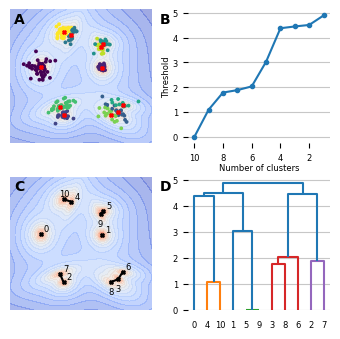

In [126]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.5, 3.5), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]}) 
axes = axes.flatten()


# 
ax = axes[0]
data_X = X
grid_resolution=128
levels=20
mixture_model = varied.mixture_model
MARKERSIZE = 6
ax.axis('off') 
ax.scatter(X[:, 0], X[:, 1], c=varied.predict(X), s=MARKERSIZE/2)

margin = 0.5
x = np.linspace(
    data_X[:, 0].min() - margin, data_X[:, 0].max() + margin, grid_resolution
)
y = np.linspace(
    data_X[:, 1].min() - margin, data_X[:, 1].max() + margin, grid_resolution
)
XY = np.stack(np.meshgrid(x, y), -1)

# get scores for the grid values
mm_probs = mixture_model.score_samples(XY.reshape(-1, 2)).reshape(
    grid_resolution, grid_resolution
)
# plotting the energy landscape
ax.contourf(
    x,
    y,
    mm_probs,
    levels=levels,
    cmap="coolwarm",
    alpha=0.5,
    zorder=-10,
)
centers = varied.mixture_model.centers
ax.scatter(centers[:, 0], centers[:, 1], c="red", marker="X", s=MARKERSIZE)
ax.tick_params(axis='both', labelsize=6)
ax.text(0.03, 0.9, 'A', transform=ax.transAxes, 
            size=10, weight='bold')
# -------------
ax = axes[2]
ax.axis('off')
our_data = X
plot_field(
    data_X=our_data,
    mixture_model=varied.mixture_model,
    paths=varied.paths_,
    selection=pairs,
    axis=ax,
    plot_points=False,
    plot_ids=True,
)

ax.tick_params(axis='both', labelsize=6)
ax.text(0.03, 0.9, 'C', transform=ax.transAxes, 
            size=10, weight='bold')
# -------------
ax = axes[1]

threshold_dict, _ = varied.get_thresholds_and_cluster_numbers()
xs = sorted(list(threshold_dict.keys()))[::-1]
ys  = [-threshold_dict[x] for x in xs]
ax.plot(xs, ys, marker="o", markersize=MARKERSIZE/2)
ax.set_xlabel("Number of clusters", fontsize=6, labelpad=1)
ax.set_ylabel("Threshold", fontsize=6, labelpad=1)
# plt.title("Clusters")
ax.grid(axis='y', alpha=0.7)
ax.invert_xaxis()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.tick_params(axis='both', labelsize=6)
ax.text(-0.2, 0.9, 'B', transform=ax.transAxes, 
            size=10, weight='bold')
# -------------
ax = axes[3]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(axis='y', alpha=0.7)
# ax.set_yticklabels([])
# ax.set_yticks([])

dendrogram(original_linkage, color_threshold=2.5, ax=ax)
ax.set_xlabel(ax.get_xlabel(), labelpad=-100)
ax.tick_params(axis='both', labelsize=6)

ax.text(-0.2, 0.9, 'D', transform=ax.transAxes, 
            size=10, weight='bold')

# -------------
plt.tight_layout()
plt.subplots_adjust(
    wspace=0.25, 
    hspace=0.25
)
plt.savefig(
    # f"{pre}figures/claude_neb_join_strategies_{dataset_name}_seed_{seed}_n_components_{n_components}.pdf",
    'intro_figure.pdf', bbox_inches='tight', pad_inches=0)